In [1]:
# This section installs packages needed to run the script. 

import folium  # Importing GeoJson class from folium library for visualizing geospatial data
import pandas as pd  # Importing pandas library and aliasing it as pd for data analysis and manipulation
import matplotlib.pyplot as plt  # Importing pyplot module from matplotlib library and aliasing it as plt for plotting
import scipy.signal  # Importing signal module from scipy library for signal processing
import numpy as np  # Importing numpy library and aliasing it as np for numerical computing
import geopandas as gpd  # Importing geopandas library and aliasing it as gpd for working with geographic data
import openeo  # Importing openeo library for working with the OpenEO API for Earth Observation data processing
from shapely.geometry import shape  # Importing shape class from geometry module of shapely library for geometric operations


In [2]:
#This establishes a connection with the Sentenel satelite data. 

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

#if this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 
#if you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 
#if there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [3]:
# This section displays a list of all the PreZero landfill sites

landfills = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\test_landfill.geojson")

landfills

,CodNIMA,CodINE,MUNICIPIO,PROVINCIA,CCAA,TipCoor,LATITUD,LONGITUD,DIRECCION,geometry
0,2.800020e+09,280796.0,Madrid,MADRID,MADRID,R,40.332515,-3.591445,CAÑADA REAL DE MERINAS S/N,POINT (-3.59145 40.33251)


In [4]:
# This section displays a map of all the PreZero landfill sites. Click any site for its name. 

# This creates the map and centres it on the geometries. 
centroids = landfills.geometry.centroid
center = [centroids.y.mean(), centroids.x.mean()]
site_map = folium.Map(location=center, zoom_start=5)

# Adding the landfill locations to the map
for feature in landfills.iterfeatures():
    # Extract feature number from properties
    feature_number = feature['properties']['DIRECCION'] #this is for the test landfill
    #feature_number = feature['properties']['Landfill'] #this is for the PreZero ones
    
    # Extract coordinates of the feature
    coordinates = feature['geometry']['coordinates']
    
    # Create a marker with label for each feature
    folium.Marker(location=[coordinates[1], coordinates[0]], 
                  popup=f"Feature {feature_number}").add_to(site_map)

# Display the map
site_map

# the warning "...Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect..." can be ignored. 

C:\Users\kinse\AppData\Local\Temp\ipykernel_18928\802533215.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = landfills.geometry.centroid


In [5]:
# This section applies a buffer of 5000m to each landfill for the analysis.

# loading dataframe
landfill_5000m = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\test_landfill.geojson")

# The dataset is projected in EPSG:4326 with its units in degrees. This needs to be converted to CRS to EPSG:2062, which is in metres. 
landfill_5000m = landfill_5000m.to_crs(epsg=2062)

# Now the dataframe is converted, a buffer of 5000m is added to each point
landfill_5000m['geometry'] = landfill_5000m.buffer(5000)

# Now the buffered data needs to be converted back to EPSG:4326 because the Sentinel data is projected in EPSG:4326.
landfill_5000m = landfill_5000m.to_crs(epsg=4326)

# The time series analysis requires that A GeoJSON format file is used for the analised areas, so this bit produces a file suitable for that.
landfill_5000m_geojson = landfill_5000m.__geo_interface__



In [6]:
# This selects the specific dataset for the time series analysis. 

s5cube_timeseries = connection.load_collection(
    "SENTINEL_5P_L2", #This selects the data from the Sentinel 5 Precursor satelite. 
    temporal_extent=["2021-08-01", "2021-10-31"], # Select a date range using the format YYYY-MM-DD
    bands=["CH4"], # The options for gas monitoring are: 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4'
)

In [7]:
# This section takes the mean values of the selected gas within each of the buffered landfill geometries for every dataset within the selected time period. 
# Sentinel 5P will provide daily values of any gas you select. 

timeseries = s5cube_timeseries.aggregate_spatial(geometries=landfill_5000m_geojson, reducer="mean")

#This saves the results as a .CSV file which can be viewed in Microsoft Excel or a similar package. It will be saved in the indicated location.
job = timeseries.execute_batch(out_format="CSV", title="CH4 timeseries")

job.get_results().download_file("CH4-results/CH4_timeseries.csv")

pd.read_csv("CH4-results/CH4_timeseries.csv", index_col=0)

0:00:00 Job 'j-240421780c054f599fd11b587ba1f2b4': send 'start'
0:00:14 Job 'j-240421780c054f599fd11b587ba1f2b4': created (progress N/A)
0:00:20 Job 'j-240421780c054f599fd11b587ba1f2b4': created (progress N/A)
0:00:26 Job 'j-240421780c054f599fd11b587ba1f2b4': created (progress N/A)
0:00:34 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:00:45 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:00:57 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:01:13 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:01:32 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:01:56 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:02:26 Job 'j-240421780c054f599fd11b587ba1f2b4': running (progress N/A)
0:03:04 Job 'j-240421780c054f599fd11b587ba1f2b4': finished (progress N/A)


,feature_index,avg(band_0)
date,,
2021-08-11T00:00:00.000Z,0,NaN
2021-08-10T00:00:00.000Z,0,1891.360107
2021-08-12T00:00:00.000Z,0,1898.404144
2021-08-09T00:00:00.000Z,0,NaN
2021-09-12T00:00:00.000Z,0,NaN
...,...,...
2021-10-12T00:00:00.000Z,0,1891.389404
2021-10-15T00:00:00.000Z,0,1935.012238
2021-10-21T00:00:00.000Z,0,NaN


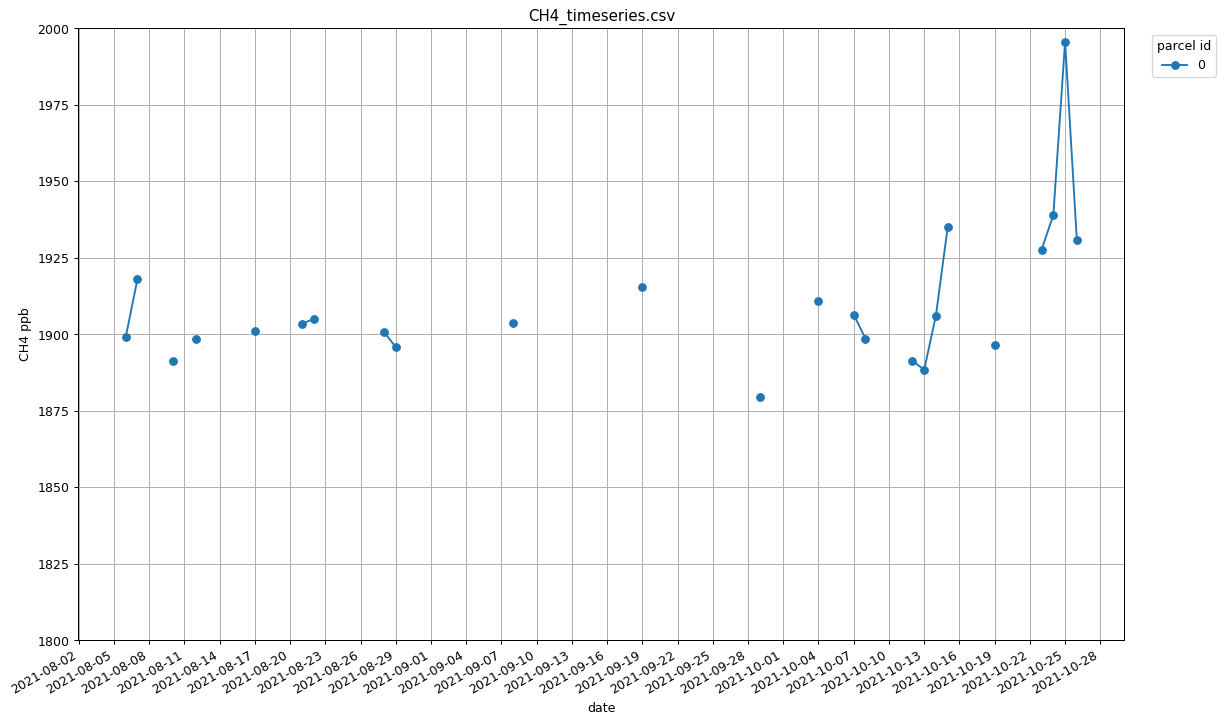

In [8]:
# This section takes the results in the .CSV file and plots it on a graph. 

def plot_timeseries(filename, figsize=(15, 10)): # modify these numbers if you want to change the width and height of the graph
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("CH4 ppb")
    ax.set_ylim(1800, 2000) # modify these numbers if you want to change the range of values for methane 
    ax.legend(title="parcel id", loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(30)) # change this number if you want to increase the number of dates displayed 
    ax.grid(True)

plot_timeseries("CH4-results/CH4_timeseries.csv")